In [34]:
import torch
import numpy as np
import pandas as pd
import sklearn
from sklearn import model_selection
import torch_geometric
from torch_geometric import utils
from tqdm import tqdm

In [35]:
df = pd.read_csv ('clear_data_realbank.csv')

df.rename(columns = {'RETAILER' : 'terminal_id', 'CustomerKey' : 'customer_id',
                        'MCC' : 'mcc', 'AMOUNT_EQ' : 'amount'   }, 
                            inplace = True) 
# некоторые id магазинов имели разные категории. Здесь id c разл категорией приравниваются к -2 и затем удаляются
for i in (range(min(df.mcc.unique()),max(df.mcc.unique())+1)):
    for j in range(i+1,max(df.mcc.unique())+1):
        for k in (set(df[df.mcc==i].terminal_id.unique())&set(df[df.mcc==j].terminal_id.unique())):
            df.loc[df.terminal_id == k,'mcc'] = -2
df = df[df.mcc != -2].reset_index(drop=True)

#изменение amount на 8 категорий
# траты разбиваются на 9 категорий и в дальнейшем будут характеризировать отношения
df.amount = pd.qcut(df.amount, q=8, 
        labels=["small", "medium_small", "medium_small_2", 'medium_1', 'medium_2', 'medium_large_2', 'medium_large', 'large'])

# некоторые связи могут дублировать друг друга, возможно следует их удалить:
# df = df.drop_duplicates(subset=['amount', 'customer_id', 'mcc'], keep='first')
# df = df.drop_duplicates(subset=['transaction_date', 'customer_id', 'mcc'], keep='first')
# df = df.drop_duplicates(subset=['Address', 'customer_id', 'mcc'], keep='first')

# # отношения характеризуются объемом трат и датой - разные виды отношений
# relations = [key for key in category_head] + list(set(df['transaction_date']))             + list(set(df['Address']))
df = df.sort_values('mcc')

df['tail_type'] = df.mcc.astype(str)
#каждая категория сущностей имеет свои id начинающиеся с 0 в каждой категории
user_dict = dict(zip(df['customer_id'].unique(), list(range(0,len(df['customer_id'].unique())))))
###shop_dict = dict(zip(df['terminal_id'].unique(), list(range(len(df['customer_id'].unique()),len(df['customer_id'].unique())+len(df['terminal_id'].unique())))))
df['customer_id'] = [user_dict[i] for i in df['customer_id']]
###df['terminal_id'] = [shop_dict[i] for i in df['terminal_id']]
for i in sorted(df.tail_type.unique()):
    df.loc[df.tail_type==i,'terminal_id'] = list(range(0,len(df[df.tail_type==i]['terminal_id'])))

In [36]:
top_mcc = list(df.mcc.value_counts()[:10].rename_axis('unique_values').reset_index(name='counts')['unique_values'])
df = df[df.mcc.isin(top_mcc)].reset_index(drop=True)

In [37]:
# df.amount = 'small'

In [38]:
df.head()

,terminal_id,customer_id,TRANS_DETAIL,mcc,tstmp,amount,tail_type
0,0,0,"OOO ""MAKSIDOM"", ST PETERBURG, RU",-1,2018-01-02 18:21:17+03:00,large,-1
1,1,1,"IP ALIEV NIFTALY, St Petersburg, RU",-1,2018-07-06 09:39:20+03:00,medium_small,-1
2,2,1,"IP ALIEV NIFTALY, St Petersburg, RU",-1,2018-12-26 22:09:25+03:00,medium_small,-1
3,3,2,"IP ALIEV NIFTALY, St Petersburg, RU",-1,2018-11-05 23:01:48+03:00,medium_small,-1
4,4,1,"IP ALIEV NIFTALY, St Petersburg, RU",-1,2018-09-25 08:22:11+03:00,medium_small,-1


In [39]:
#graph = torch.load(r'processed/data_processed', 'rb')

'''
--- edge_index_dict --- словарь, key - вид отношения, value - array из двух списков head и tail
--- num_nodes_dict --- количество сущностей в каждой категории
--- edge_reltype --- словарь, key - вид отношения, value - [порядковый номер отношения] * количество отношений
'''
edge_index_dict = dict()
num_nodes_dict = dict()
num_nodes_dict['person'] = len(df.customer_id.unique())
edge_reltype = dict()
count = 0
for i in sorted(df.tail_type.unique()):
    num_nodes_dict[str(i)] = len(df[df.tail_type==i].terminal_id.unique())
for i in sorted(df.amount.unique()):
    edge_index_dict[str(i)] = np.array([df[df['amount']==i]['customer_id'], df[df['amount']==i]['terminal_id']])
    edge_reltype[str(i)] = np.array([count]*len(edge_index_dict[str(i)][0])).reshape(len(edge_index_dict[str(i)][0]),1)
    count += 1
# for i in sorted(df.Address.unique()):
#     edge_index_dict[str(i)] = np.array([df[df['Address']==i]['customer_id'], df[df['Address']==i]['terminal_id']])
#     edge_reltype[str(i)] = np.array([count]*len(edge_index_dict[str(i)][0])).reshape(len(edge_index_dict[str(i)][0]),1)
#     count += 1
# for i in sorted(df.transaction_date.unique()):
#     edge_index_dict[str(i)] = np.array([df[df['transaction_date']==i]['customer_id'], df[df['transaction_date']==i]['terminal_id']])
#     edge_reltype[str(i)] = np.array([count]*len(edge_index_dict[str(i)][0])).reshape(len(edge_index_dict[str(i)][0]),1)
#     count += 1

graph = {
    'edge_index_dict': edge_index_dict,
    'edge_feat_dict': None,
    'node_feat_dict': None,
    'num_nodes_dict': num_nodes_dict,
    'edge_reltype': edge_reltype
}

torch.save(graph, r'data_processed', pickle_protocol=4)

In [40]:
# graph = torch.load(r'data_processed', 'rb')

In [41]:
sum(graph['num_nodes_dict'].values())

3111763

In [42]:
#dataset_df = pd.read_csv ('dataset_pre.csv')
def Dataset(name_relation):
    dataset = pd.DataFrame(columns = ['head_type', 'head', 'relation', 'tail_type', 'tail'])

    dataset['head_type'] = ['person']*len(df['customer_id'])
    dataset['head'] = df['customer_id']
    dataset['tail'] = df['terminal_id']
    dataset['tail_type'] = df['tail_type']
    dataset['relation'] = [edge_reltype[str(key)][0][0] for key in df[name_relation]]
    dataset['tail_type'] = [str(i) for i in dataset['tail_type']]
    dataset['tstmp'] = df['tstmp']
    return dataset

dataset_amount = Dataset('amount')
# dataset_Address = Dataset('Address')
# dataset_transaction_date = Dataset('transaction_date')

# dataset_df = pd.concat([dataset_amount, dataset_Address, dataset_transaction_date],axis = 0, ignore_index=True)
dataset_df = pd.concat([dataset_amount],axis = 0, ignore_index=True)
dataset_df = dataset_df.sort_values('relation')

dataset_df.to_csv('dataset_pre.csv', index=False)

In [43]:
dataset_df

,head_type,head,relation,tail_type,tail,tstmp
0,person,0,0,-1,0,2018-01-02 18:21:17+03:00
2680054,person,1346,0,5,28163,2018-12-12 00:00:00+03:00
2680053,person,3757,0,5,28162,2018-11-02 00:00:00+03:00
2680052,person,3757,0,5,28161,2018-11-14 00:00:00+03:00
2680051,person,1346,0,5,28160,2018-10-28 00:00:00+03:00
...,...,...,...,...,...,...
179086,person,2190,7,0,20958,2018-03-08 18:36:55+03:00
179088,person,1848,7,0,20960,2018-12-14 05:55:02+03:00
179089,person,1848,7,0,20961,2018-03-18 07:01:59+03:00
179075,person,2992,7,0,20947,2018-05-23 08:42:31+03:00


In [44]:
train = dataset_df[(dataset_df.tstmp >= '2018-01-01 00:00:00+03:00') & (dataset_df.tstmp < '2018-08-01 00:00:00+03:00')]
train.drop('tstmp', inplace=True, axis=1)
valid = dataset_df[(dataset_df.tstmp >= '2018-08-01 00:00:00+03:00') & (dataset_df.tstmp < '2018-10-01 00:00:00+03:00')]
valid.drop('tstmp', inplace=True, axis=1)
test = dataset_df[(dataset_df.tstmp >= '2018-10-01 00:00:00+03:00') & (dataset_df.tstmp < '2019-01-01 00:00:00+03:00')]
test.drop('tstmp', inplace=True, axis=1)
print('TRAIN: ', round(len(train)/len(dataset_df)*100))
print('VALID: ', round(len(valid)/len(dataset_df)*100))
print('TEST: ', round(len(test)/len(dataset_df)*100))

c:\Users\Elena\anaconda3\envs\ml\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


TRAIN:  58
VALID:  17
TEST:  25


In [45]:
# train, test = sklearn.model_selection.train_test_split(dataset_df, shuffle=False, test_size=0.2) #random_state=2020
# valid, test = sklearn.model_selection.train_test_split(test, shuffle=False, test_size=0.5)

In [46]:
train = train.sort_values('relation')
test = test.sort_values('relation')
valid = valid.sort_values('relation')

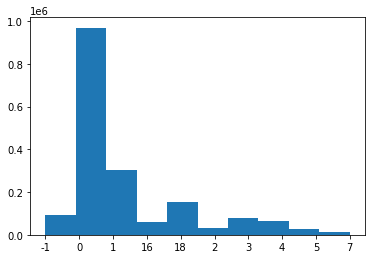

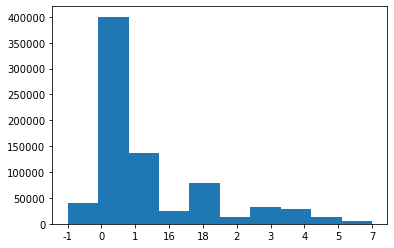

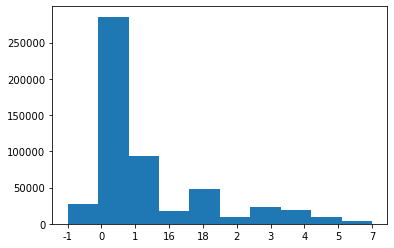

In [47]:
import matplotlib.pyplot as plt
plt.hist(train.tail_type.sort_values())
plt.show()
plt.hist(test.tail_type.sort_values())
plt.show()
plt.hist(valid.tail_type.sort_values())
plt.show()

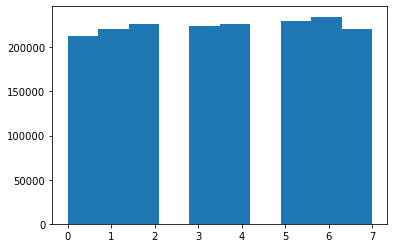

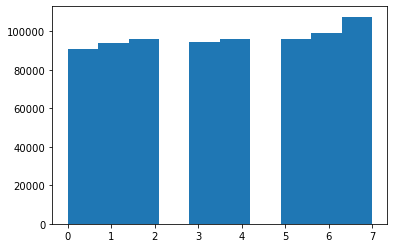

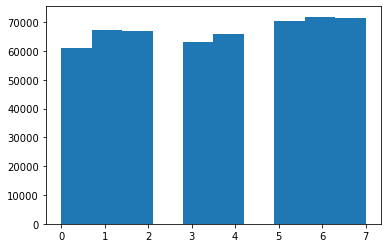

In [48]:
plt.hist(train.relation.sort_values())
plt.show()
plt.hist(test.relation.sort_values())
plt.show()
plt.hist(valid.relation.sort_values())
plt.show()

In [49]:
from random import randint,choice
dict_df_cat = {}
sample_neg = {}
num_neg = 1000
for i in tqdm(dataset_df.tail_type.unique()):
     term = dataset_df[dataset_df.tail_type==i]
     dict_df_cat[i] = [np.array(term['head']),np.array(term['tail'])]
     heads_n = []
     tails_n = []
     for j in (range(num_neg)):
          head_n = randint(0,num_nodes_dict['person']-1)
          # tail_n = randint(0,num_nodes_dict[i]-1)
          mask = dict_df_cat[i][0]==head_n
          tails = set(range(0,num_nodes_dict[i]-1)) - set(dict_df_cat[i][1][mask])
          tail_n = choice(list(tails))
          heads_n.append(head_n)
          tails_n.append(tail_n)
     sample_neg[i] = [np.array(heads_n),np.array(tails_n)]
     #sample_neg[i] = torch_geometric.utils.negative_sampling(edge_index=torch.LongTensor(dict_df_cat[i]), num_neg_samples=num_neg, force_undirected = True)

100%|██████████| 10/10 [03:58<00:00, 23.86s/it]


In [50]:
from random import sample
head_neg_test = []
tail_neg_test = []
for idx in tqdm(test.index):
    t = test.loc[idx,'tail_type']
    indexs = np.array(sample(range(0,num_neg),10))
    head_neg_test.append(list(sample_neg[t][0][indexs] ))
    tail_neg_test.append(list(sample_neg[t][1][indexs] ))

head_neg_valid = []
tail_neg_valid = []
for idx in tqdm(valid.index):
    t = valid.loc[idx,'tail_type']
    indexs = np.array(sample(range(0,num_neg),10))
    head_neg_valid.append(list(sample_neg[t][0][indexs] ))
    tail_neg_valid.append(list(sample_neg[t][1][indexs] ))

100%|██████████| 537326/537326 [00:15<00:00, 33616.19it/s]


In [51]:
train = train.to_dict(orient='list')
test = test.to_dict(orient='list')
valid = valid.to_dict(orient='list')

In [52]:
#relation_dict = dict(zip(edge_index_dict.keys(),range(len(edge_index_dict.keys()))))

train_dict = {
    'head_type': list(train['head_type']),
    'head': np.array(train['head']),
    'relation': np.array(train['relation']),
    'tail_type': list(train['tail_type']),
    'tail': np.array(train['tail']),
}

test_dict = {
    'head_type': list(test['head_type']),
    'head': np.array(test['head']),
    'head_neg': np.array(head_neg_test),
    #'head_neg': test['head_neg'],
    'relation': np.array(test['relation']),
    'tail_type': list(test['tail_type']),
    'tail': np.array(test['tail']),
    'tail_neg': np.array(tail_neg_test),
    #'tail_neg': test['tail_neg']
}

valid_dict = {
    'head_type': list(valid['head_type']),
    'head': np.array(valid['head']),
    'head_neg': np.array(head_neg_valid),
    #'head_neg': valid['head_neg'],
    'relation': np.array(valid['relation']),
    'tail_type': list(valid['tail_type']),
    'tail': np.array(valid['tail']),
    'tail_neg': np.array(tail_neg_valid),
    #'tail_neg': valid['tail_neg']
}

torch.save(train_dict, r'train.pt')
torch.save(test_dict, r'test.pt')
torch.save(valid_dict, r'valid.pt')

In [53]:
train = torch.load(r'train.pt')
test = torch.load(r'test.pt')
valid = torch.load(r'valid.pt')

In [54]:
test.keys()

dict_keys(['head_type', 'head', 'head_neg', 'relation', 'tail_type', 'tail', 'tail_neg'])

In [55]:
test['relation']

array([0, 0, 0, ..., 7, 7, 7])

In [56]:
#dataset_df = pd.read_csv ('dataset_pre.csv')
# dataset_df = pd.DataFrame(columns = ['head_type', 'head', 'relation', 'tail_type', 'tail'])
# head = []
# tail = []
# relat = []
# tail_type = []
# mcc_dict = dict(zip(df.terminal_id, df.mcc))
# for key,value in edge_index_dict.items():
#     head += list(value[0])
#     tail += list(value[1])
#     tail_type += [str(mcc_dict[t]) for t in list(value[1])]
#     relat += [edge_reltype[key][0][0]]*len(value[0])

    
# dataset_df['head_type'] = ['person']*len(head)
# dataset_df['head'] = head
# dataset_df['tail'] = tail
# dataset_df['tail_type'] = tail_type
# dataset_df['relation'] = relat

# #dataset_df.to_csv('dataset_pre.csv', index=False)

In [57]:
# #graph = torch.load(r'processed/data_processed', 'rb')
# df = pd.read_csv ('dataset.csv')
# edge_index_dict = dict()
# num_nodes_dict = dict()
# edge_reltype = dict()

# count = 0
# for key_head in category_head:
#     flag = True

#     bottom = category_head[key_head][0]
#     upper = category_head[key_head][1]
#     my_query_head = 'amount>=@bottom & amount<@upper'
#     term_head = df.query(my_query_head)
#     num_nodes_dict[key_head] = len(term_head)
    
#     for key_tail in df['mcc'].unique(): 
#         my_query_tail = 'mcc==@key_tail'
#         if flag:
#             term_tail = df.query(my_query_tail)
#             num_nodes_dict[key_tail] = len(term_tail)
#         term = term_head.query(my_query_tail)
#         if len(term)!=0:
#             edge_index_dict[(key_head,f'{key_head}-{key_tail}',key_tail)] = np.vstack((term['customer_id'],term['terminal_id']))
#             edge_reltype[(key_head,f'{key_head}-{key_tail}',key_tail)] = np.array([count]*len(term)).reshape(len(term),1)
#             count += 1
    
#     flag = False

# graph = {
#     'edge_index_dict': edge_index_dict,
#     'edge_feat_dict': None,
#     'node_feat_dict': None,
#     'num_nodes_dict': num_nodes_dict,
#     'edge_reltype': edge_reltype
# }

# torch.save(graph, r'processed/data_processed', pickle_protocol=4)

In [58]:
#dataset_df = pd.read_csv ('dataset_pre.csv')

# dataset_df = pd.DataFrame(columns = ['head_type', 'head', 'relation', 'tail_type', 'tail'])
# dataset_df['head_type'] = [type for amount in df['amount'] for type in category_head if category_head[type][0]<=amount<category_head[type][1]]
# dataset_df['head'] = df['customer_id']
# dataset_df['tail_type'] = df['mcc']
# dataset_df['tail'] = df['terminal_id']
# dataset_df['relation'] = [str(dataset_df['head_type'][i])+'-'+str(dataset_df['tail_type'][i]) for i in range(len(df))]

# user_dict = dict(zip(dataset_df['head'].unique(), list(range(1,len(dataset_df['head'].unique())+1))))
# shop_dict = dict(zip(dataset_df['tail'].unique(), list(range(len(dataset_df['head'].unique())+1,len(dataset_df['head'].unique())+len(dataset_df['tail'].unique())+1))))
# dataset_df['head'] = [user_dict[i] for i in dataset_df['head']]
# dataset_df['tail'] = [shop_dict[i] for i in dataset_df['tail']]

# dataset_df.to_csv('dataset_pre.csv', index=False)

In [59]:
# negative_sampl = torch_geometric.utils.negative_sampling(edge_index=torch.Tensor([dataset_df['head'],dataset_df['tail']]), num_neg_samples=len(valid)*100)

In [60]:
# train = pd.DataFrame(train).sort_values('relation').to_dict(orient='list')
# test = pd.DataFrame(test).sort_values('relation').to_dict(orient='list')
# valid = pd.DataFrame(valid).sort_values('relation').to_dict(orient='list')

# head_neg = np.array(negative_sampl[0])
# tail_neg = np.array(negative_sampl[1])

In [61]:
# maxx = max(dataset_df['head'].unique())

# head_neg = np.array([], dtype = int)
# tail_neg = np.array([], dtype = int)

# negative_sampl_array = np.array(negative_sampl)
# for i in tqdm(range(len(negative_sampl_array[0]))):
#     if negative_sampl_array[1][i]>maxx and negative_sampl_array[0][i]<=maxx:
#         head_neg = np.append(head_neg, negative_sampl_array[0][i])
#         tail_neg = np.append(tail_neg, negative_sampl_array[1][i])
#     elif negative_sampl_array[0][i]>maxx and negative_sampl_array[1][i]<=maxx:
#         head_neg = np.append(head_neg, negative_sampl_array[1][i])
#         tail_neg = np.append(tail_neg, negative_sampl_array[0][i])

In [62]:
# head_neg_valid, tail_neg_valid = head_neg[:len(head_neg)//2], head_neg[:len(tail_neg)//2]
# head_neg_test, tail_neg_test = head_neg[len(head_neg)//2:], head_neg[len(tail_neg)//2:]

# head_neg_valid = head_neg_valid[:(len(head_neg_valid)//len(valid))*len(valid)]
# tail_neg_valid = tail_neg_valid[:(len(tail_neg_valid)//len(valid))*len(valid)]
# head_neg_test = head_neg_test[:(len(head_neg_test)//len(test))*len(test)]
# tail_neg_test = tail_neg_test[:(len(tail_neg_test)//len(test))*len(test)]

# head_neg_valid = head_neg_valid.reshape(len(valid), -1)
# tail_neg_valid = tail_neg_valid.reshape(len(valid), -1)
# head_neg_test = head_neg_test.reshape(len(test), -1)
# tail_neg_test = tail_neg_test.reshape(len(test), -1)

In [63]:
graph.keys()

dict_keys(['edge_index_dict', 'edge_feat_dict', 'node_feat_dict', 'num_nodes_dict', 'edge_reltype'])